### Imports

In [1]:
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, ReLU, BatchNormalization, Flatten, Dense, Dropout, ReLU, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import pickle
from glob import glob
import cv2
import random
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
import math

Using TensorFlow backend.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Variables

In [3]:
columns_df_2D_interest = ['RightShoulder_2D','RightShoulder_2D.1',
                          'RightElbow_2D', 'RightElbow_2D.1',
                          'RightHand_2D','RightHand_2D.1',
                          'LeftShoulder_2D','LeftShoulder_2D.1',
                          'LeftElbow_2D', 'LeftElbow_2D.1', 
                          'LeftHand_2D','LeftHand_2D.1']

columns_df_3D_interest = ['RightShoulder','RightShoulder.1','RightShoulder.2',
                          'RightElbow', 'RightElbow.1','RightElbow.2',
                          'RightHand','RightHand.1','RightHand.2',
                          'LeftShoulder','LeftShoulder.1','LeftShoulder.2',
                          'LeftElbow', 'LeftElbow.1', 'LeftElbow.2',
                          'LeftHand','LeftHand.1','LeftHand.2']

mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}

keypoints_number = 6

### Functions

In [4]:
def split_nd_coordinates_array(coordinates_array, n): 
    m = 0
    r = n
    frame_coordinates = []
    for j in range(0,int(len(coordinates_array)/n)):
        frame_coordinates.append(coordinates_array[m:r])
        m = r
        r = r+n
    return(np.array(frame_coordinates))

###  Load dataset

In [5]:
df_mocap_2D = pd.read_csv('../../../datasets/RGSClinic/No-Gravity/Dataset_MoCap_RGSclinic_KinectCamera.csv')[columns_df_2D_interest]
df_mocap_3D  = pd.read_csv('../../../datasets/RGSClinic/No-Gravity/Dataset_MoCap_RGSclinic_KinectCamera.csv')[columns_df_3D_interest]

print(df_mocap_2D.shape)
print(df_mocap_2D.shape)

(32948, 12)
(32948, 12)


#### 2D and 3D data augmentation via horizontal flipping

In [6]:
#2D augmentation via flipping x axis
height,width = (1080,1920)

flipped_list_2D = []
for i in range(0,len(df_mocap_2D)):
    frame_keypoint_coordinates = split_nd_coordinates_array(np.array(df_mocap_2D.iloc[i]),2)
    flipped_frame_coordinates_x = width - frame_keypoint_coordinates[:,0]
    flipped_array = np.zeros([6,2])
    flipped_array[:,0] = flipped_frame_coordinates_x
    flipped_array[:,1] = frame_keypoint_coordinates[:,1]
    
    #Transforming it to vector(12,)
    flipped_array = flipped_array.reshape(-1)
    flipped_list_2D.append(flipped_array)

#To map the dataframe columns into its flipped corresponding keypoint name
flipped_columns_names_2D = [
    'LeftShoulder_2D','LeftShoulder_2D.1',
    'LeftElbow_2D','LeftElbow_2D.1',
    'LeftHand_2D','LeftHand_2D.1',
    'RightShoulder_2D','RightShoulder_2D.1',
    'RightElbow_2D','RightElbow_2D.1',
    'RightHand_2D','RightHand_2D.1']
                        
flipped_2D_df = pd.DataFrame(flipped_list_2D).rename(columns=dict(enumerate(flipped_columns_names_2D)))

#Sorting it in the same order as the original dataframe to append it
flipped_2D_df = flipped_2D_df[['RightShoulder_2D','RightShoulder_2D.1','RightElbow_2D','RightElbow_2D.1','RightHand_2D','RightHand_2D.1', 'LeftShoulder_2D','LeftShoulder_2D.1','LeftElbow_2D','LeftElbow_2D.1','LeftHand_2D','LeftHand_2D.1']]
df_mocap_2D = df_mocap_2D.append(flipped_2D_df).reset_index().drop(columns=['index'])

#3D data augmentation via flipping x axis

flipped_list_3D = []
for i in range(0,len(df_mocap_3D)):
    frame_3d_keypoint_coordinates_x = np.array(split_nd_coordinates_array(np.array(df_mocap_3D.iloc[i]),3))

    
    flipped_3d_array = np.zeros([6,3])
    flipped_3d_array[:,0] = -frame_3d_keypoint_coordinates_x[:,0]
    flipped_3d_array[:,1] = frame_3d_keypoint_coordinates_x[:,1]
    flipped_3d_array[:,2] = frame_3d_keypoint_coordinates_x[:,2]
    
    flipped_3d_array = flipped_3d_array.reshape(-1)
    flipped_list_3D.append(flipped_3d_array)

flipped_columns_names_3D = [
    'LeftShoulder', 'LeftShoulder.1', 'LeftShoulder.2',
    'LeftElbow', 'LeftElbow.1', 'LeftElbow.2', 
    'LeftHand', 'LeftHand.1','LeftHand.2',
    'RightShoulder', 'RightShoulder.1', 'RightShoulder.2', 
    'RightElbow','RightElbow.1', 'RightElbow.2', 
    'RightHand', 'RightHand.1','RightHand.2', ]

flipped_3D_df = pd.DataFrame(flipped_list_3D).rename(columns=dict(enumerate(flipped_columns_names_3D)))
flipped_3D_df = flipped_3D_df[['RightShoulder', 'RightShoulder.1', 'RightShoulder.2', 'RightElbow',
       'RightElbow.1', 'RightElbow.2', 'RightHand', 'RightHand.1',
       'RightHand.2', 'LeftShoulder', 'LeftShoulder.1', 'LeftShoulder.2',
       'LeftElbow', 'LeftElbow.1', 'LeftElbow.2', 'LeftHand', 'LeftHand.1',
       'LeftHand.2']]
df_mocap_3D = df_mocap_3D.append(flipped_3D_df).reset_index().drop(columns=['index'])

In [7]:
df_mocap_2D.shape

(65896, 12)

In [8]:
df_mocap_3D.shape

(65896, 18)

### Noise addition

In [9]:
def split_2_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 2
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/2)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+2
        output.append(frame_coordinates)
    return(output)

In [10]:
df_2D_original_splitted = pd.DataFrame(split_2_coordinates(np.array(df_mocap_2D)))
df_2D_noise1 = []
for i in range(0,df_2D_original_splitted.shape[0]):
    row_keypoint_numbers = []
    for j in range(0,df_2D_original_splitted.shape[1]):
        
        circle_r = 100 #Maximum radius
        
        circle_x = df_2D_original_splitted.iloc[i][j][0]
        circle_y = df_2D_original_splitted.iloc[i][j][1]
        
        alpha = 2 * math.pi * random.random()
        # random radius
        r = circle_r * math.sqrt(random.random())
        
        # calculating coordinates
        x = r * math.cos(alpha) + circle_x
        x = round(x,2)
        
        y = r * math.sin(alpha) + circle_y
        y = round(y,2)
        
        row_keypoint_numbers.append(x)
        row_keypoint_numbers.append(y)
    df_2D_noise1.append(row_keypoint_numbers)
    
    
df_2D_noise1 = pd.DataFrame(df_2D_noise1)
    
df_mocap_2D = df_2D_noise1
df_mocap_2D.head(5)
print(df_mocap_2D.shape)

(65896, 12)


### Data normalization

In [11]:
scaler_2d = StandardScaler()
scaler_3d = StandardScaler()
df_mocap_2D = pd.DataFrame(scaler_2d.fit_transform(np.array(df_mocap_2D)), columns = columns_df_2D_interest)
df_mocap_3D = pd.DataFrame(scaler_3d.fit_transform(np.array(df_mocap_3D)), columns = columns_df_3D_interest)

#### Data preprocessing to create spatio-temporal graph

Taking window length of 5 and sliding the window by one frame --> Data augmentation

In [12]:
r0 = 0
rf = 5
windowed_df_mocap_2D = []
windowed_df_mocap_3D = []
prueba = []

while rf <= int(np.rint(df_mocap_2D.shape[0])):

    windowed_df_mocap_2D.append(np.array(df_mocap_2D.iloc[r0:rf]))
    windowed_df_mocap_3D.append(np.array(df_mocap_3D.iloc[r0:rf]))
    r0 += 1
    rf += 1  

### Reversing the input sequence (2D) as sugested by Sutsekver et al. 

By reversing the order of the input but not the target (3D) in training and test set it can be introduced a short term dependency that make the optimization problem much simpler

In [13]:
windowed_df_mocap_2D_reversed = []
for i in range(0,len(windowed_df_mocap_2D)):
    windowed_df_mocap_2D_reversed.append(np.flip(windowed_df_mocap_2D[i], axis=0))

In [14]:
encoder_input_data = np.array(windowed_df_mocap_2D_reversed)
decoder_input_data = np.array(windowed_df_mocap_3D)
decoder_target_data = decoder_input_data.copy()
#decoder_target_data[0][0] = np.ones([18])

### Train Test split shuffle no

In [15]:
X_train, X_test, y_train, y_test = train_test_split(np.array(windowed_df_mocap_2D_reversed), np.array(windowed_df_mocap_3D), test_size=0.1, random_state=27)
print(X_train.shape)
print(y_train.shape)

(59302, 5, 12)
(59302, 5, 18)


In [16]:
print(X_test.shape)
print(y_test.shape)

(6590, 5, 12)
(6590, 5, 18)


### Seq2Seq network definition

In [17]:
initializer = keras.initializers.glorot_uniform()

encoder_inputs = keras.layers.Input(shape=(5, 12))
encoder_l1 = keras.layers.LSTM(1536, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = keras.layers.RepeatVector(5)(encoder_outputs1[0])

#
decoder_l1 = keras.layers.LSTM(1536, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = keras.layers.TimeDistributed(keras.layers.Dense(18))(decoder_l1)

#
model= keras.models.Model(encoder_inputs,decoder_outputs1)



initial_learning_rate = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1e3,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
             loss = 'mean_squared_error',
             metrics=['mse'])

#
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 12)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 1536), (None 9517056     input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 1536)      0           lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 5, 1536)      18880512    repeat_vector_1[0][0]            
                                                                 lstm_1[0][1]               

In [18]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MPG]')
    plt.plot(hist['epoch'], hist['mse'], alpha = 0.7,label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

In [19]:
checkpoint = ModelCheckpoint("../models/Non_Gravity/noise_lvl4/model.h5", monitor='loss', verbose=1,save_best_only=True, mode='auto', period=50)
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


EPOCHS = 100
history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=EPOCHS,
          validation_split=0.15,
          verbose = 1,
          callbacks=[checkpoint]  )

Train on 50406 samples, validate on 8896 samples
Epoch 1/100
50406/50406 [==============================] - 48s 943us/step - loss: 0.0720 - mse: 0.0720 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 2/100
50406/50406 [==============================] - 47s 934us/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 3/100
50406/50406 [==============================] - 47s 934us/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 4/100
50406/50406 [==============================] - 47s 933us/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 5/100
50406/50406 [==============================] - 47s 936us/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 6/100
50406/50406 [==============================] - 47s 936us/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 7/100
50406/50406 [==============================] - 47s 940us/step - loss: 0.0150 - mse: 0.0150 - val_lo

C:\Users\rgseq\anaconda3\envs\RGSpipe\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


50406/50406 [==============================] - 47s 940us/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 52/100
50406/50406 [==============================] - 47s 936us/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 53/100
50406/50406 [==============================] - 47s 937us/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 54/100
50406/50406 [==============================] - 47s 935us/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 55/100
50406/50406 [==============================] - 47s 938us/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 56/100
50406/50406 [==============================] - 47s 941us/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 57/100
50406/50406 [==============================] - 47s 940us/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0115 - val_mse: 0.0115 loss: 0.0116 - mse
Epoch 5

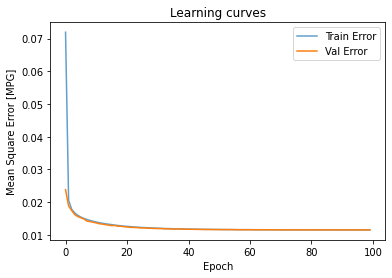

In [20]:
#Plotting learning curves
plot_history(history)

In [21]:
#Download the standard scaler
pickle.dump(scaler_2d, open('../models/Non_Gravity/noise_lvl4/scaler_2D.pkl','wb'))
pickle.dump(scaler_3d, open('../models/Non_Gravity/noise_lvl4/scaler_3D.pkl','wb'))

### Testing

To decode a test pose, we will repeatedly:

1. Encode the input pose and retrieve the initial decoder state
2. Run one step of the decoder with this initial state and a "start of sequence" token as target. The output will be the next target character.
3. Append the target character predicted and repeat.

In [20]:
model = keras.models.load_model('../models/Non_Gravity/2d_gt/model.h5')
scaler_2D = pickle.load(open('../models/Non_Gravity/2d_gt/scaler_2D.pkl','rb'))
scaler_3D = pickle.load(open('../models/Non_Gravity/2d_gt/scaler_3D.pkl','rb'))                                

OSError: Unable to open file (unable to open file: name = './models/4th_test_different_arch/model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [22]:
y_predicted = model.predict(X_test)

#### Compute MPJPE

In [23]:
all_distances = []
for i in range(0,y_test.shape[0]):
    gt_splitted = split_nd_coordinates_array(y_test[i][4],3)
    pred_splitted = split_nd_coordinates_array(y_predicted[i][4],3)
    keypoints_distances = []
    for j in range(0,pred_splitted.shape[0]):
        keypoints_distances.append(distance.euclidean(gt_splitted[j], pred_splitted[j]))
    all_distances.append(keypoints_distances)
    
df_PJPE = pd.DataFrame(all_distances).rename(columns=mapping_numbers_variables)

In [24]:
means = []
for column in list(df_PJPE.columns):
    means.append(df_PJPE[column].mean())
    
mpjpe = sum(means)/len(df_PJPE.columns)
print('The obtained MPJPE error is: '+'\033[1m'+str(mpjpe*100)+'cm')

The obtained MPJPE error is: 15.909724396087418cm


In [26]:
df_PJPE.mean()*100

right_shoulder    13.183985
right_elbow       15.431440
right_wrist       12.297987
left_shoulder     13.069906
left_elbow        15.295949
left_wrist        12.450002
dtype: float64

In [27]:
df_PJPE.std()*100

right_shoulder     8.106207
right_elbow       10.044989
right_wrist        8.123389
left_shoulder      7.670724
left_elbow         9.708398
left_wrist         8.189408
dtype: float64

([<matplotlib.axis.XTick at 0x1d298f2beb8>,
 [Text(1, 0, 'right_shoulder'),
  Text(2, 0, 'right_elbow'),
  Text(3, 0, 'right_wrist'),
  Text(4, 0, 'left_shoulder'),
  Text(5, 0, 'left_elbow'),
  Text(6, 0, 'left_wrist')])

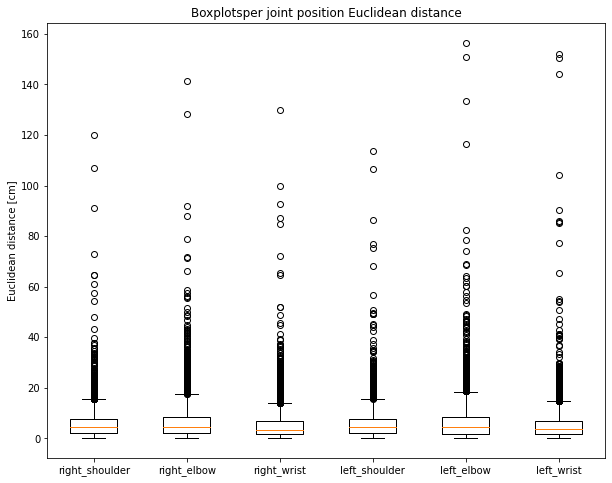

In [27]:
fig = plt.figure(figsize=(10,8))
plt.boxplot(df_PJPE*100)
plt.title('Boxplotsper joint position Euclidean distance')
plt.ylabel('Euclidean distance [cm]')
#plt.ylim([0,80])
positions = list(mapping_numbers_variables.keys())
positions = [i+1 for i in positions]
labels = list(mapping_numbers_variables.values())
plt.xticks(positions,labels)